In [1]:
import os
import requests
import shutil
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
tf.__version__

'2.0.0'

In [2]:
# Get features types dict and features list
content = requests.get('http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names').text
buf, *features = content.split('\n')[:-1]
attack_types = buf.split(',')
attack_types[-1] = attack_types[-1][:-1]
features_types_dict = {f.split(':')[0]: f.split(':')[1][1:-1] for f in features}
features = list(features_types_dict.keys())
features_types_dict

{'duration': 'continuous',
 'protocol_type': 'symbolic',
 'service': 'symbolic',
 'flag': 'symbolic',
 'src_bytes': 'continuous',
 'dst_bytes': 'continuous',
 'land': 'symbolic',
 'wrong_fragment': 'continuous',
 'urgent': 'continuous',
 'hot': 'continuous',
 'num_failed_logins': 'continuous',
 'logged_in': 'symbolic',
 'num_compromised': 'continuous',
 'root_shell': 'continuous',
 'su_attempted': 'continuous',
 'num_root': 'continuous',
 'num_file_creations': 'continuous',
 'num_shells': 'continuous',
 'num_access_files': 'continuous',
 'num_outbound_cmds': 'continuous',
 'is_host_login': 'symbolic',
 'is_guest_login': 'symbolic',
 'count': 'continuous',
 'srv_count': 'continuous',
 'serror_rate': 'continuous',
 'srv_serror_rate': 'continuous',
 'rerror_rate': 'continuous',
 'srv_rerror_rate': 'continuous',
 'same_srv_rate': 'continuous',
 'diff_srv_rate': 'continuous',
 'srv_diff_host_rate': 'continuous',
 'dst_host_count': 'continuous',
 'dst_host_srv_count': 'continuous',
 'dst_hos

In [3]:
# Get attack types dict
content = requests.get('http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types').text
buf = content.split('\n')[:-2]
target_classes = {
    'normal': 0,
    'u2r': 1,
    'r2l': 2,
    'probe': 3,
    'dos': 4
}
attack_types_dict = {line.split()[0]: line.split()[1] for line in buf}
attack_types_dict['normal'] = 'normal'
attack_types_dict

{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'normal': 'normal'}

In [4]:
#Get data
_URL = 'http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz'

zip_file = tf.keras.utils.get_file(origin=_URL,
                                   fname="kddcup.data.gz",
                                   extract=True)

In [5]:
# Extract zip file with data
import gzip
import shutil

data_file = 'kddcup_data'

with gzip.open(zip_file, 'rb') as f_in:
    with open(data_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [6]:
# Number of data samples
!wc -l {data_file}

4898431 kddcup_data


In [7]:
# Load data into df
data = pd.read_csv(data_file, 
                      header=None, 
                      names=features + ['label'])
data['label'] = [i[:-1] for i in data['label'].values]
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


In [8]:
# Unnormalized numerical features
num_attrs = []
for i in [0, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 22, 31, 32]:
    num_attrs.append(features[i])
num_attrs

['duration',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'count',
 'dst_host_count',
 'dst_host_srv_count']

In [9]:
# Categorical features
cat_attrs = []
for i in [1, 2, 3]:
    cat_attrs.append(features[i])
cat_attrs

['protocol_type', 'service', 'flag']

In [10]:
# Classification of data
label_counts_dict = data['label'].value_counts()
print('+', '-' * 7, '+', '-' * 16, '+', '-' * 8, '+', sep='')
print('|%-6s |%-15s |%-7s |' % ('Class', "Attack type", 'Count'))
print('+', '-' * 7, '+', '-' * 16, '+', '-' * 8, '+', sep='')
for (count, attack_type) in zip(label_counts_dict, label_counts_dict.keys()):
    print('|%-6s |%-15s |%-7d |' % (attack_types_dict[attack_type], attack_type, count))
    print('+', '-' * 7, '+', '-' * 16, '+', '-' * 8, '+', sep='')

+-------+----------------+--------+
|Class  |Attack type     |Count   |
+-------+----------------+--------+
|dos    |smurf           |2807886 |
+-------+----------------+--------+
|dos    |neptune         |1072017 |
+-------+----------------+--------+
|normal |normal          |972781  |
+-------+----------------+--------+
|probe  |satan           |15892   |
+-------+----------------+--------+
|probe  |ipsweep         |12481   |
+-------+----------------+--------+
|probe  |portsweep       |10413   |
+-------+----------------+--------+
|probe  |nmap            |2316    |
+-------+----------------+--------+
|dos    |back            |2203    |
+-------+----------------+--------+
|r2l    |warezclient     |1020    |
+-------+----------------+--------+
|dos    |teardrop        |979     |
+-------+----------------+--------+
|dos    |pod             |264     |
+-------+----------------+--------+
|r2l    |guess_passwd    |53      |
+-------+----------------+--------+
|u2r    |buffer_overflow |30

In [11]:
# Detect small and numerous classes
numerous_classes = ['smurf', 'neptune', 'normal', 'satan', 'ipsweep', 'portsweep']
small_classes = ['nmap', 'back', 'warezclient', 'teardrop']

In [12]:
# Form training, test and validation dataframes
train_df, test_df, val_df = data[1:2], data[2:3], data[3:4]

TRAIN_NUM = 2000
TEST_NUM = 200

for cl in numerous_classes:
    train_df = train_df.merge(data[data['label']==cl][:TRAIN_NUM], how='outer')
    test_df = test_df.merge(data[data['label']==cl][TRAIN_NUM:TRAIN_NUM+TEST_NUM], how='outer')
    val_df = val_df.merge(data[data['label']==cl][TRAIN_NUM+TEST_NUM:TRAIN_NUM+TEST_NUM+TEST_NUM], how='outer')

for cl in small_classes:
    TRAIN_NUM = round(len(data[data['label']==cl]) * 0.8)
    TEST_NUM = round(len(data[data['label']==cl]) * 0.1)
    train_df = train_df.merge(data[data['label']==cl][:TRAIN_NUM], how='outer')
    test_df = test_df.merge(data[data['label']==cl][TRAIN_NUM:TRAIN_NUM+TEST_NUM], how='outer')
    val_df = val_df.merge(data[data['label']==cl][TRAIN_NUM+TEST_NUM:TRAIN_NUM+TEST_NUM+TEST_NUM], how='outer')
    
print('train_df: ', len(train_df))
print('test_df:  ', len(test_df))
print('val_df:   ', len(val_df))

train_df:  17214
test_df:   1853
val_df:    1852


In [13]:
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

# Define a data pipeline for a RandomForestClassifier    
def pipeline(data):
    df = data.copy()
    cat_encoder = LabelBinarizer()
    scaler = MinMaxScaler()
    for attr in cat_attrs:
        df[attr] = cat_encoder.fit_transform(df[attr].values.reshape(-1, 1))
    for attr in num_attrs:
        df[attr] = scaler.fit_transform(df[attr].values.reshape(-1, 1))
    return df

In [14]:
# Fit RandomForestClassifier to know feature importances
from sklearn.ensemble import RandomForestClassifier

train_data = pipeline(train_df)
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(train_data.drop('label', axis=1), train_data['label'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [26]:
# Determine the accuracy of a trained model
from sklearn.metrics import classification_report, confusion_matrix

test_data = pipeline(test_df)
true_labels = test_data.pop('label')
predicted_labels = rnd_clf.predict(test_data)
print('\nConfusion matrix:\n', confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))


Confusion matrix:
 [[220   0   0   0   0   0   0   0   0   0]
 [  0 200   0   0   0   0   0   0   0   0]
 [  0   0 200   0   0   0   0   0   0   0]
 [  0   0   0 172   0   0   0  60   0   0]
 [ 26   0   0  18  42   0   0   0   0 115]
 [  0   0   0   0   0 200   0   0   0   0]
 [  0   0   0   0   0   0 200   0   0   0]
 [  0   0   0   0   0   0   0 200   0   0]
 [  0   0   0   0   0   0   0   0  98   0]
 [  0   0   0   0   0   0   0   0   0 102]]
              precision    recall  f1-score   support

        back       0.89      1.00      0.94       220
     ipsweep       1.00      1.00      1.00       200
     neptune       1.00      1.00      1.00       200
        nmap       0.91      0.74      0.82       232
      normal       1.00      0.21      0.35       201
   portsweep       1.00      1.00      1.00       200
       satan       1.00      1.00      1.00       200
       smurf       0.77      1.00      0.87       200
    teardrop       1.00      1.00      1.00        98
 warezcl

In [15]:
# Based on RandomForestClassifier, determine feature importances
print('+', '-' * 28, '+', '-' * 16, '+', sep='')
print('|%-27s |%-s|' % ('Feature', 'Importance(in %)'))
print('+', '-' * 28, '+', '-' * 16, '+', sep='')
for (feature, importance) in zip(features_types_dict, rnd_clf.feature_importances_):
    print('|%-28s|%-16f|' % (feature, importance * 100))
    print('+', '-' * 28, '+', '-' * 16, '+', sep='')

+----------------------------+----------------+
|Feature                     |Importance(in %)|
+----------------------------+----------------+
|duration                    |0.306152        |
+----------------------------+----------------+
|protocol_type               |1.633718        |
+----------------------------+----------------+
|service                     |0.000633        |
+----------------------------+----------------+
|flag                        |0.014057        |
+----------------------------+----------------+
|src_bytes                   |7.408090        |
+----------------------------+----------------+
|dst_bytes                   |6.175795        |
+----------------------------+----------------+
|land                        |0.000000        |
+----------------------------+----------------+
|wrong_fragment              |2.101593        |
+----------------------------+----------------+
|urgent                      |0.000000        |
+----------------------------+----------

In [16]:
# Determine number of important features depending on their percentage of contribution
d = {i: imp for i, imp in enumerate(rnd_clf.feature_importances_)}
for bias in [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
    print('>', bias * 100, '%: ', len(list(filter(lambda x: d[x] > bias, d))))

> 0.0 %:  34
> 1.0 %:  25
> 2.0 %:  21
> 3.0 %:  16
> 4.0 %:  9
> 5.0 %:  7
> 6.0 %:  6


In [17]:
# Define data pipeline for NN model 
def df_to_dataset(input_df, main_df=data, bias = 0.05, shuffle=True, batch_size=32):
    """
    Performs data preprocessing.
    
    param data: pandas.Dataframe
    """
    df = input_df.copy()
    cat_encoder = LabelBinarizer()
    scaler = MinMaxScaler()
    for attr in cat_attrs:
        cat_encoder.fit(main_df[attr].values.reshape(-1, 1))
        df[attr] = cat_encoder.transform(df[attr].values.reshape(-1, 1))
    for attr in num_attrs:
        scaler.fit(main_df[attr].values.reshape(-1, 1))
        df[attr] = scaler.fit_transform(df[attr].values.reshape(-1, 1))
            
    d = dict(zip(features, rnd_clf.feature_importances_)) # dict(feature: feature_importance)
    df = df.drop(list(filter(lambda x: d[x] < bias, d)), axis=1) # drop unimportance features

    df['label'] = df['label'].apply(lambda x: target_classes[attack_types_dict[x]]) # 10 classes > 4 main classes
    df['label'], _ = df['label'].factorize()
        
    labels = df.pop('label')
    dataset = tf.data.Dataset.from_tensor_slices((df.values, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    print(f'Features count: {len(df.columns)}')
    print('Сlass distribution: ', dict(labels.value_counts()))
    return dataset

In [29]:
# Form training, test and validation datasets
BATCH_SIZE = 32
BIAS = 0.02

train_dataset = df_to_dataset(train_df, bias=BIAS, batch_size=BATCH_SIZE)
val_dataset = df_to_dataset(val_df, bias=BIAS, batch_size=BATCH_SIZE)
test_dataset = df_to_dataset(test_df,bias=BIAS, batch_size=BATCH_SIZE)

Features count: 21
Сlass distribution:  {2: 7853, 1: 6545, 0: 2000, 3: 816}
Features count: 21
Сlass distribution:  {2: 831, 1: 718, 0: 201, 3: 102}
Features count: 21
Сlass distribution:  {2: 832, 1: 718, 0: 201, 3: 102}


In [30]:
# Determine logs dir for TensorBoard
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [31]:
# Define model
def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(21, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [32]:
# Compile and fit model
model = get_compiled_model()
epochs = 30
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    use_multiprocessing=True, 
                    epochs=epochs,
                    callbacks=[tensorboard_callback]
                   )


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/30
538/538 [==============================] - 1s 2ms/step - loss: 3.4157 - accuracy: 0.5465 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
538/538 [==============================] - 1s 1ms/step - loss: 0.8587 - accuracy: 0.6497 - val_loss: 0.6489 - val_accuracy: 0.6361
Epoch 3/30
538/538 [==============================] - 1s 1ms/step - loss: 0.6410 - accuracy: 0.7155 - val_loss: 0.5428 - val_accuracy: 0.7862
Epoch 4/30
538/538 [==============================] - 1s 1ms/step - loss: 

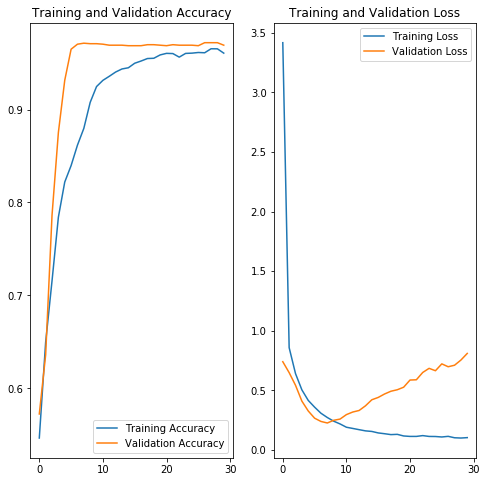

In [33]:
# Check accuracy and loss curves
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
# Check accuracy on test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Accuracy on test dataset:', test_accuracy)

58/58 [==============================] - 0s 596us/step - loss: 0.8802 - accuracy: 0.9579
Accuracy on test dataset: 0.9579061


In [35]:
def labels_to_list(data):
    df = data.copy()
    df['label'] = df['label'].apply(lambda x: target_classes[attack_types_dict[x]]) # 10 classes > 4 main classes
    df['label'], _ = df['label'].factorize()
    return df['label'].values.tolist()

In [36]:
# Check confusion matrix on test dataset and get classification report
predict_labels = model.predict(df_to_dataset(test_df, bias=BIAS, shuffle=False, batch_size=BATCH_SIZE))
predicted_labels = [np.argmax(predict) for predict in predict_labels]
true_labels = labels_to_list(test_df)
print('\nConfusion matrix:\n', confusion_matrix(true_labels, predicted_labels))
print(classification_report(true_labels, predicted_labels))

Features count: 21
Сlass distribution:  {2: 832, 1: 718, 0: 201, 3: 102}

Confusion matrix:
 [[135  12  41  13]
 [  1 706   3   8]
 [  0   0 832   0]
 [  0   0   0 102]]
              precision    recall  f1-score   support

           0       0.99      0.67      0.80       201
           1       0.98      0.98      0.98       718
           2       0.95      1.00      0.97       832
           3       0.83      1.00      0.91       102

    accuracy                           0.96      1853
   macro avg       0.94      0.91      0.92      1853
weighted avg       0.96      0.96      0.96      1853

